In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'R_RLC.csv'
fr = pd.read_csv(FILE)

In [25]:
Vin = np.array(fr['Vin']) # V
VR = np.array(fr['VR']) # V
VLC = np.array(fr['V_LC']) # V
ν = np.array(fr['Freq (Hz)']) # Hz 
ω = 2*np.pi*ν # rad/s
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦL = np.array(fr['faseLC (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = np.array(fr['sigmaV_in']) # media 4 = sqrt(16)
sigma_VR = np.array(fr['sigmaV_R']) # media 4 = sqrt(16)
sigma_VL = np.array(fr['sigmaV_LC'])

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro
RL = 40
sigmaRL = RL * 0.01

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) /4 # rad
sigma_ΦLC = np.array(fr['sigmaF_LC'], dtype=np.float64) * (np.pi/180.0) /4 # rad

- $|H_R(\omega)| = \frac{\omega CR}{\sqrt{(1-\omega^2LC)^2 + \omega^2C^2 (R+R_L)^2}}$

- $\angle H_R(\omega) = -arctan(\frac{\omega C(R+R_L)}{1-\omega^2LC})$

In [26]:
def mod_HR_f(omega, C,L):
    numerator = omega * C * R
    denominator = np.sqrt((1 - (omega**2) * L * C)**2 + (omega**2) * (C**2) * (R + RL)**2)
    result = numerator / denominator
    return result

def arg_HR_f(omega, C,L):
    numerator = omega * C * (R + RL)
    denominator = 1 - (omega**2) * L * C
    angle = -np.arctan(numerator / denominator)
    return angle

In [27]:
modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((1/(Vin))*sigma_VR)**2)

In [29]:
fit_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[100*10**-9,0.04])
print(fit_HR)

ValueError: array must not contain infs or NaNs

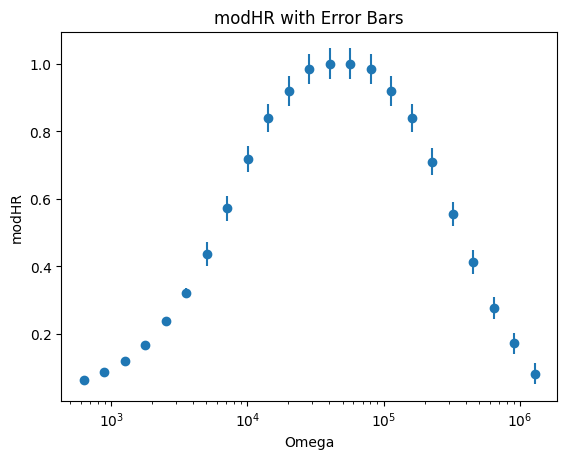

In [ ]:
plt.errorbar(ω, modHR, yerr=sigma_modHR, fmt='o')
plt.xlabel('Omega')
plt.ylabel('modHR')
plt.xscale('log')
plt.title('modHR with Error Bars')
plt.show()